In [1]:
from sklearn.datasets import make_blobs
from sklearn import cluster
from sklearn import metrics
from base import tools
import multiprocessing
import itertools
%matplotlib inline
import mpld3
mpld3.disable_notebook()
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
X, y = make_blobs(2000, 40, 7, cluster_std=5)

In [5]:
sils = []
clust_range = range(2, 20)
for n in clust_range:
    clust = cluster.MiniBatchKMeans(n_clusters = n)
    clust.fit(X)
    sils.append(metrics.silhouette_score(X, clust.predict(X)))

/Users/aleph4/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [6]:
sils = pd.DataFrame({'sil' : sils, 'n': clust_range})

In [7]:
sils['random'] = False

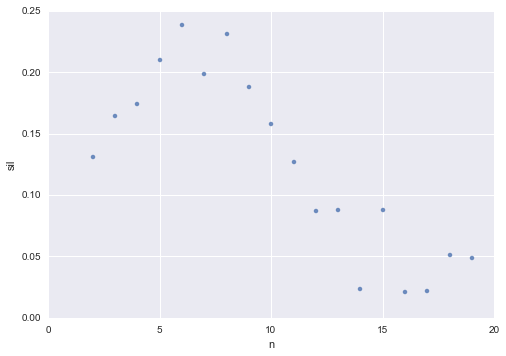

In [8]:
sns.regplot('n', 'sil', sils, fit_reg=False)

In [ ]:
def parallel_clust(args):
    X, n = args
    new_X = np.apply_along_axis(np.random.permutation, 0, X)
    clust = cluster.MiniBatchKMeans(n_clusters = n)
    clust = clust.fit(new_X)

    return metrics.silhouette_score(new_X, clust.predict(new_X))

In [ ]:
pool = multiprocessing.Pool()
pb = tools.ProgressBar(len(clust_range), start=True)

perm_sils = []
for n in clust_range:
    rep_sils = []
    for sil in pool.imap(parallel_clust, itertools.repeat((X, n), 30)):
        rep_sils.append(sil)
    pb.next()
    rep_sils = pd.DataFrame({'sil': rep_sils})
    rep_sils['n'] = n
    perm_sils.append(rep_sils)

[##] 22%

In [ ]:
boot_sils = pd.concat(perm_sils)

In [ ]:
boot_sils['random'] = 'cluster_boot'

In [ ]:
cluster_boot_sils = pd.concat([sils, boot_sils])

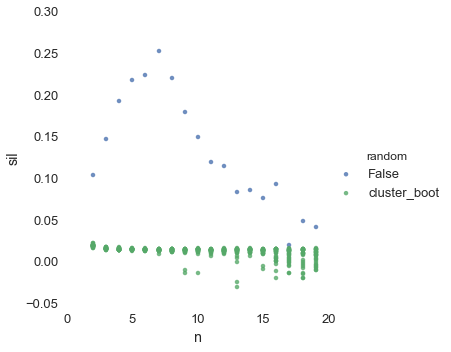

In [121]:
sns.set_context('talk')
sns.lmplot('n', 'sil', cluster_boot_sils, hue='random', fit_reg=False)

### Shuffling labels not re-doing clustering

In [10]:
def random_sil(args):
    n, X, labels = args
    
    return [n, metrics.silhouette_score(X, np.random.permutation(labels)), True]

In [ ]:
sils = []
clust_range = range(2, 20)
pb = tools.ProgressBar(len(clust_range), start=True)
pool = multiprocessing.Pool()


for n in clust_range:
    clust = cluster.MiniBatchKMeans(n_clusters = n)
    clust.fit(X)
    labels = clust.predict(X)
    sils.append([n, metrics.silhouette_score(X, labels), False])
    
    for sil in pool.imap(random_sil, itertools.repeat((n, X, labels), 30)):
        sils.append(sil)
        
    pb.next()

In [126]:
simple_boot_sils = pd.DataFrame(sils, columns=['n', 'sil', 'random'])

In [127]:
simple_boot_sils

,n,sil,random
0,2,0.120543,False
1,2,0.000626,True
2,2,-0.000167,True
3,2,-0.000021,True
4,2,0.000475,True
5,2,0.000026,True
6,2,0.000286,True
7,2,0.000282,True
8,2,0.000361,True
9,2,0.000391,True


In [128]:
simple_boot_sils.random = simple_boot_sils.random.replace(True, 'simple_perm')

In [129]:
simple_boot_sils.random = simple_boot_sils.random.replace(False, 'real')

In [130]:
all_sils = pd.concat([simple_boot_sils, boot_sils])

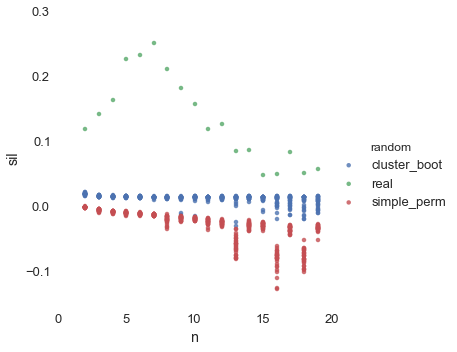

In [131]:
sns.lmplot('n', 'sil', all_sils, hue='random', fit_reg=False)

In [132]:
from scipy import stats

In [133]:
all_sils[all_sils.random == 'simple_perm'].sil.corr(all_sils[all_sils.random == "cluster_boot"].sil)

-0.054498355917839927

In [134]:
mean_s = all_sils.groupby(['n', 'random']).mean().reset_index()

In [135]:
mean_s.pivot_table(columns=['random'])

random,cluster_boot,real,simple_perm
n,10.500000,10.500000,10.500000
sil,0.013913,0.134973,-0.026624


In [136]:
stats.pearsonr(mean_s[mean_s.random == 'cluster_boot'].sil, mean_s[mean_s.random == 'simple_perm'].sil)

(0.78934096919136876, 9.8260721175911223e-05)

(array([ 1.,  0.,  1.,  6.,  4.,  3.,  9.,  3.,  2.,  1.]),
 array([-0.0140208 , -0.01330279, -0.01258478, -0.01186677, -0.01114876,
        -0.01043074, -0.00971273, -0.00899472, -0.00827671, -0.0075587 ,
        -0.00684069]),
 <a list of 10 Patch objects>)

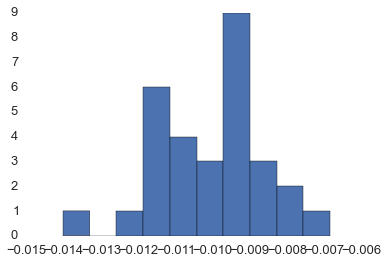

In [159]:
plt.hist(np.array(all_sils[(all_sils.n == 6) &( all_sils.random == "simple_perm")].sil))

In [152]:
np.array(all_sils[(all_sils.n == 10) &( all_sils.random == "simple_perm")].sil)

array([-0.01883726, -0.02043846, -0.01939074, -0.01628166, -0.01628369,
       -0.01462872, -0.02031148, -0.01855426, -0.01843951, -0.01645826,
       -0.01625455, -0.01803101, -0.01553579, -0.01619516, -0.01827963,
       -0.01512233, -0.01719888, -0.01849112, -0.01996203, -0.0158022 ,
       -0.01939676, -0.02099679, -0.02148267, -0.01556944, -0.0195034 ,
       -0.01561993, -0.01660391, -0.01851765, -0.01977531, -0.01836295])